<a href="https://colab.research.google.com/github/skitw427/Layerwise-XAI/blob/main/notebook_demo/Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import timm
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import ast
import os

In [47]:
def load_imagenet_classes(filepath):
    with open(filepath, "r") as f:
        classes = ast.literal_eval(f.read())
    return classes

model_name = "resnet18.a1_in1k"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model(model_name, pretrained=True)
model.eval()
model = model.to(device)

In [48]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [49]:
imagenet_classes_path = "/content/drive/Othercomputers/내 컴퓨터/drive/imagenet-mini/imagenet_classes.txt"
imagenet_classes = load_imagenet_classes(imagenet_classes_path)

print(len(imagenet_classes))

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_dir = 'cat/'

image_tensors = []
for filename in os.listdir(image_dir):
    if filename.endswith('.JPEG'):
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image)
        image_tensors.append(image_tensor)

if image_tensors:
    input_tensor = torch.stack(image_tensors)
    print(f"Input tensor shape: {input_tensor.shape}")
else:
    print("No JPEG images found in the specified directory.")

1000
Input tensor shape: torch.Size([8, 3, 224, 224])


In [102]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, ScoreCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

mean = [0.485, 0.456, 0.406]
std =  [0.229, 0.224, 0.225]

target_layers = [model.layer4[-1]]
targets = [ClassifierOutputTarget(283) for _ in range(input_tensor.shape[0])]

rgb_img = input_tensor.cpu().numpy().copy()

print(rgb_img.shape)
for b in range(rgb_img.shape[0]):
  for c in range(rgb_img.shape[1]):  # 채널(R/G/B)
    rgb_img[b, c, :, :] = rgb_img[b, c, :, :] * std[c] + mean[c]

rgb_img = rgb_img.transpose(0, 2, 3, 1)

print(rgb_img.shape)


# Construct the CAM object once, and then re-use it on many images.
with GradCAM(model=model, target_layers=target_layers) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=input_tensor, targets=targets, aug_smooth=False, eigen_smooth=False)
  # In this example grayscale_cam has only one image in the batch:
  #grayscale_cam = grayscale_cam[0, :]
  #visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
  # You can also get the model outputs without having to redo inference
  visualizations = []
  for i in range(grayscale_cam.shape[0]):
    grayscale_cam_img = grayscale_cam[i]
    visualization = show_cam_on_image(rgb_img[i], grayscale_cam_img, use_rgb=True)
    visualizations.append(visualization)
  model_outputs = cam.outputs

visualizations = np.stack(visualizations)
print(visualizations.shape)

(8, 3, 224, 224)
(8, 224, 224, 3)
(8, 224, 224, 3)


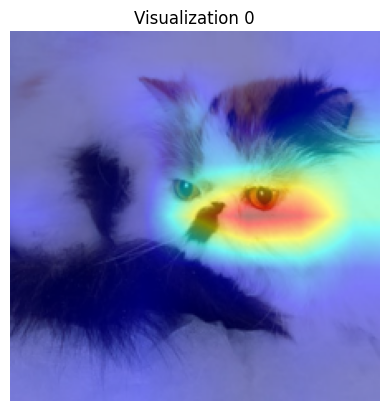

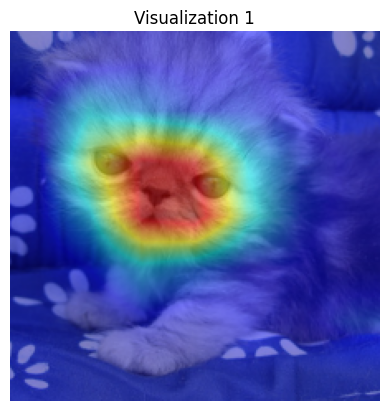

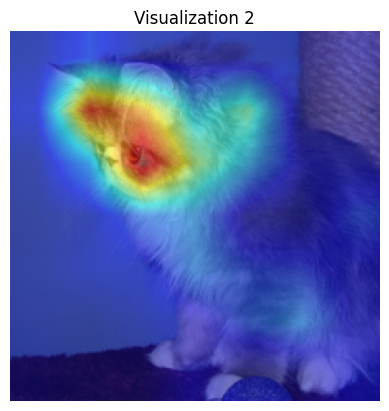

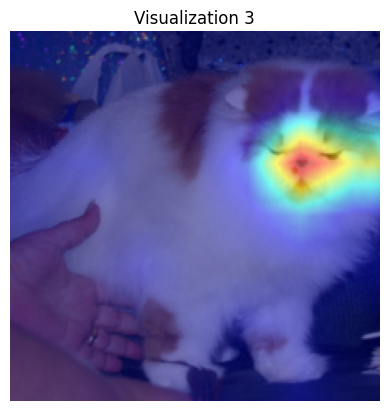

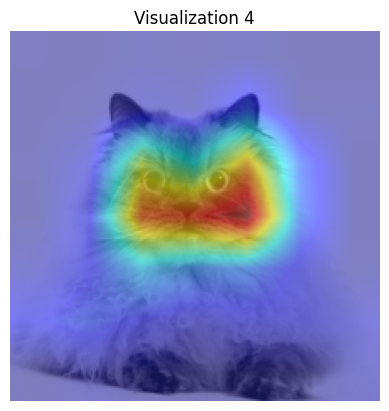

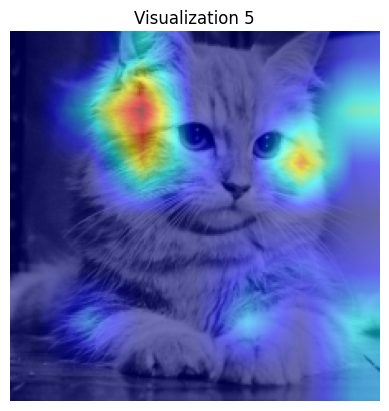

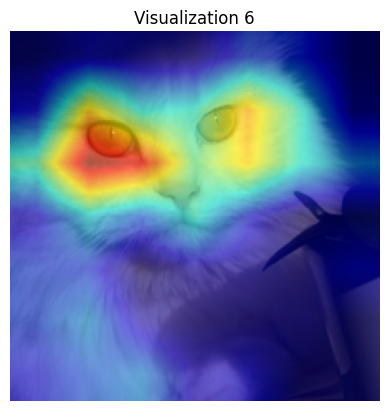

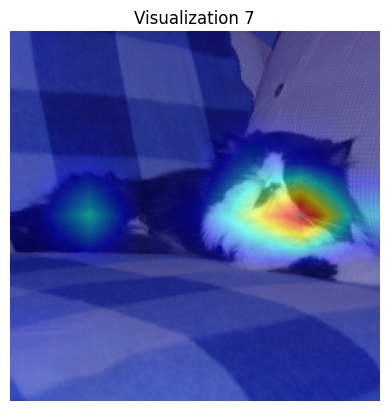

In [103]:
# plt.imshow(visualization)
# plt.show()

# print(model_outputs)

# Display all visualizations using matplotlib
for idx, vis in enumerate(visualizations):
    plt.imshow(vis)
    plt.title(f"Visualization {idx}")
    plt.axis("off")
    plt.show()